In [28]:
import geopandas as gpd
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
from dem_stitcher.geojson_io import read_geojson_gzip, to_geojson_gzip
from shapely.geometry import Polygon, shape
import asf_search as asf
import concurrent.futures
from tqdm import tqdm
import mpire
import backoff
import requests
import contextily as cx

In [2]:
START_DATE = '2020-10-01'
END_DATE = '2022-12-01'
MINIMUM_SAMPLES_PER_SITE_AND_BURST = 90 # for prior to December 21, 2021 we expect ~60 samples per year; after we expect 30
N_TROPICAL_SITES = 10
TROPICAL_BUFFER_DEG = 5

# Read the disturbance Data

In [3]:
df_dist_hls_val = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/referenceTimeSeries_last.csv')
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


# Extracting "change" and Last observed "no change" indices

In [4]:
def get_index(data: list[str], val: str) -> int:
    try:
        ind = data.index(val)
    except ValueError:
        ind = len(data)
    return ind


def get_first_change(labeled_ts):
    get_index_p = lambda val: get_index(labeled_ts, val)
    indices = list(map(get_index_p, ['VLmin', 'VLmaj', 'OCmin', 'OCmaj']))
    ind = min(indices)
    ind = ind if ind < len(labeled_ts) else -1
    return ind

def get_last_noChange(labeled_ts, change_ind):
    if change_ind == -1:
        return -1
    labeled_ts_r = (labeled_ts[:change_ind][::-1])
    ind_nc_r = get_index(labeled_ts_r, 'noChange')
    ind_nc = change_ind - ind_nc_r - 1
    return ind_nc

Debugging/testing

In [5]:
IND_T = 2
row_data = list(df_dist_hls_val.iloc[IND_T])
ts_labeled = row_data[5:]
ind_c = get_first_change(ts_labeled)
ts_labeled[max(ind_c-10, 0): ind_c+10], ind_c

(['noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin',
  'VLmin'],
 119)

In [6]:
ind_nc = get_last_noChange(ts_labeled, ind_c)
ts_labeled[max(ind_nc, 0) : ind_c+ 1], ind_c

(['noChange',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'noObs',
  'VLmin'],
 119)

## Extract dates from Table

In [7]:
def get_first_change_from_row(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        change_date = dates[ind_c]
    else:
        change_date = pd.NaT
    return change_date

def get_last_obs_date_before_change(row):
    change_label = row['overallLabel']
    if change_label in ['VLmin', 'VLmaj', 'OCmaj', 'OCmin']:
        dates_str = row.keys().tolist()[5:]
        dates = pd.to_datetime(dates_str)
        
        labeled_ts = list(row)[5:]
        ind_c = get_first_change(labeled_ts)
        ind_nc = get_last_noChange(labeled_ts, ind_c)
        last_obs_date = dates[ind_nc] if ind_nc > -1 else pd.NaT
    else:
        last_obs_date = pd.NaT

    return last_obs_date


In [8]:
df_dist_hls_val.head()

,ID,overallLabel,Long,Lat,changetype,20211001,20211002,20211003,20211004,20211005,...,20220921,20220922,20220923,20220924,20220925,20220926,20220927,20220928,20220929,20220930
0,1,VLmaj,-52.379792,-23.297147,Natural browning,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs,noObs
1,2,noChange,129.850328,-29.577240,No Change,noObs,noObs,noObs,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
2,3,VLmin,-98.600559,33.771004,Natural browning,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs
3,4,VLmaj,19.332894,4.574903,Fire,noObs,noObs,noChange,noChange,noChange,...,noChange,noChange,noChange,noChange,noChange,noChange,noChange,noObs,noObs,noObs
4,5,VLmaj,115.619006,63.108089,Fire,noObs,noObs,noObs,noObs,noObs,...,noChange,noChange,noChange,noChange,noObs,noObs,noObs,noObs,noObs,noObs


In [9]:
change_times = df_dist_hls_val.apply(get_first_change_from_row, axis=1)
last_obs_times = df_dist_hls_val.apply(get_last_obs_date_before_change, axis=1)
change_labels = df_dist_hls_val.overallLabel[:10]
print(list(zip(change_times,last_obs_times, change_times > last_obs_times ,change_labels)))

[(Timestamp('2021-10-08 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2022-01-28 00:00:00'), Timestamp('2022-01-06 00:00:00'), True, 'VLmin'), (Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-02 00:00:00'), True, 'VLmaj'), (Timestamp('2022-05-18 00:00:00'), Timestamp('2022-05-11 00:00:00'), True, 'VLmaj'), (Timestamp('2021-10-03 00:00:00'), NaT, False, 'VLmaj'), (NaT, NaT, False, 'noChange'), (Timestamp('2021-11-12 00:00:00'), Timestamp('2021-11-03 00:00:00'), True, 'OCmin'), (NaT, NaT, False, 'noChange'), (NaT, NaT, False, 'noChange')]


In [10]:
df_sites = gpd.GeoDataFrame({'site_id': df_dist_hls_val.ID,
                             'change_label': df_dist_hls_val.overallLabel,
                             'change_time': change_times,
                             'last_observation_time': last_obs_times},
                             geometry=gpd.points_from_xy(df_dist_hls_val.Long,
                                                         df_dist_hls_val.Lat),
                            crs=CRS.from_epsg(4326))

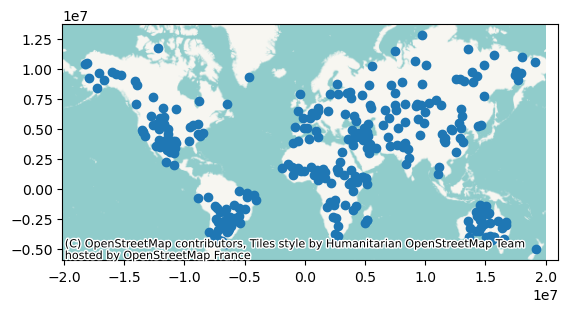

In [11]:
ax = df_sites.to_crs(epsg=3857).plot()
cx.add_basemap(ax)

In [22]:
df_sites.head()

,site_id,change_label,change_time,last_observation_time,geometry
0,1,VLmaj,2021-10-08,NaT,POINT (-52.37979 -23.29715)
1,2,noChange,NaT,NaT,POINT (129.85033 -29.57724)
2,3,VLmin,2022-01-28,2022-01-06,POINT (-98.60056 33.77100)
3,4,VLmaj,2021-11-07,2021-11-02,POINT (19.33289 4.57490)
4,5,VLmaj,2022-05-18,2022-05-11,POINT (115.61901 63.10809)


In [23]:
df_sites_meta = pd.read_csv('https://raw.githubusercontent.com/OPERA-Cal-Val/DIST-Validation/main/sampledpixels1214.csv')
df_sites_meta = df_sites_meta[['ID', 'MGRS']].copy()
df_sites_meta.rename(columns={'ID': 'site_id', 'MGRS': 'mgrs_tile_id'}, inplace=True)
df_sites = pd.merge(df_sites, df_sites_meta, on='site_id')
df_sites.head()

,site_id,change_label,change_time,last_observation_time,geometry,mgrs_tile_id
0,1,VLmaj,2021-10-08,NaT,POINT (-52.37979 -23.29715),22KCV
1,2,noChange,NaT,NaT,POINT (129.85033 -29.57724),52JEN
2,3,VLmin,2022-01-28,2022-01-06,POINT (-98.60056 33.77100),14SNC
3,4,VLmaj,2021-11-07,2021-11-02,POINT (19.33289 4.57490),34NCL
4,5,VLmaj,2022-05-18,2022-05-11,POINT (115.61901 63.10809),50VMR


In [30]:
df_sites.to_file('dist_hls_val_sites.geojson', driver='GeoJSON')

In [ ]:
site_lut = df_sites[['site_id', 'geometry']].set_index('site_id').to_dict()
site_lut['geometry'][1]

# Burst Ids

In [14]:
df_burst = read_geojson_gzip('../1_visualize_rtc_time_series/opera_burst_ids.geojson.zip')
df_burst.head()

,geometry,burst_id_jpl,is_land,is_north_america,orbit_pass
0,"POLYGON ((2.53190 4.75701, 3.29631 4.91201, 3....",t001_000025_iw1,1,False,ASCENDING
1,"POLYGON ((3.25912 4.97460, 4.06055 5.13657, 4....",t001_000025_iw2,1,False,ASCENDING
2,"POLYGON ((4.02659 5.18854, 4.73485 5.32978, 4....",t001_000025_iw3,1,False,ASCENDING
3,"POLYGON ((2.49611 4.92361, 3.26087 5.07851, 3....",t001_000026_iw1,1,False,ASCENDING
4,"POLYGON ((3.22392 5.14115, 4.02565 5.30297, 3....",t001_000026_iw2,1,False,ASCENDING


# Join Burst table and the site ids

Via a spatial join

In [15]:
df_val_bursts = gpd.sjoin(df_burst, df_sites, how='inner', predicate='intersects').reset_index(drop=True)
df_val_bursts = df_val_bursts.drop_duplicates()
df_val_bursts = df_val_bursts.drop(columns=['index_right'])
df_val_bursts['track_number'] = df_val_bursts.burst_id_jpl.map(lambda burst_id_jpl: int(burst_id_jpl.split('_')[0][1:]))
df_val_bursts = df_val_bursts.sort_values(by=['site_id', 'burst_id_jpl']).reset_index(drop=True)
df_val_bursts.rename(columns={'burst_id_jpl': 'jpl_burst_id'}, inplace=True)
df_val_bursts.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number
0,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2...",t090_193169_iw1,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,90
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97
2,"POLYGON ((-53.01716 -23.54912, -52.25936 -23.3...",t163_349964_iw3,1,False,ASCENDING,1,VLmaj,2021-10-08,NaT,163
3,"POLYGON ((129.82540 -29.63759, 130.62076 -29.4...",t039_083584_iw3,1,False,ASCENDING,2,noChange,NaT,NaT,39
4,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75


In [16]:
df_val_bursts.shape

(1117, 10)

<Axes: >

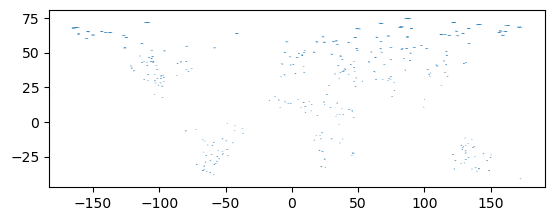

In [17]:
df_val_bursts.plot()

Serializing all the bursts.

In [18]:
df_val_bursts.to_file('dist_val_bursts.geojson', driver='GeoJSON')

# Multiple bursts overlapping

This is particlarly present at high latitudes. We see multiple tracks overlap. We see that there are 11 distinct bursts overlapping site 80!

In [19]:
df_burst_count = df_val_bursts[['site_id', 'orbit_pass']].groupby('site_id').count().sort_values(by='orbit_pass', ascending=False).reset_index(drop=False)
df_burst_count.head(10)

,site_id,orbit_pass
0,80,11
1,36,10
2,45,9
3,85,9
4,49,9
5,157,9
6,81,8
7,71,8
8,39,8
9,218,8


<Axes: >

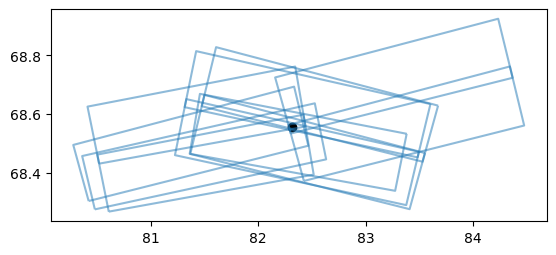

In [20]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts[df_val_bursts.site_id == 80].exterior.plot(ax=ax, alpha=.5)

We can better select a suitable burst by calculating the distance from the burst centroid to the Site. This helps find bursts that will likely give us as much context about the site as possible.

In [21]:
def distance_to_site_burst(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

The sorting of the data

In [22]:
df_val_bursts['dist_from_site_to_burst_centroid'] = df_val_bursts.apply(distance_to_site_burst, axis=1)
df_val_bursts.sort_values(by=['site_id', 'orbit_pass','dist_from_site_to_burst_centroid'], inplace=True)

## Get only 1 bursts from ASC/DSC

Since the data is now ordered by its proximity to the site, we can select the topmost entry in each group of `site_id` and `orbit_pass` (i.e. ascending/descending).

In [23]:
df_val_bursts_filtered = df_val_bursts.groupby(['site_id', 'orbit_pass']).head(1).reset_index(drop=True)
df_val_bursts_filtered.shape, df_val_bursts.shape

((600, 11), (1117, 11))

<Axes: >

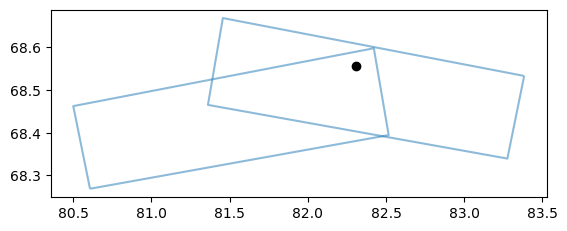

In [24]:
fig, ax = plt.subplots()
df_site = df_sites[df_sites.site_id == 80].plot(ax=ax, color='black')
df_val_bursts_filtered[df_val_bursts_filtered.site_id == 80].exterior.plot(ax=ax, alpha=.5)

# Getting SLC IDs

Now that we have the burst for each ascending/descending pass we will use, we query the ASF DAAC for the SLC metadata we need.

In [25]:
@backoff.on_exception(backoff.expo,
                      (requests.exceptions.ReadTimeout,
                       requests.exceptions.ConnectionError,
                      RuntimeError))
def get_asf_results(*,geo: Point,
                    site_id: int,
                    track_number: int,
                    jpl_burst_id: str,
                    **kwargs):
    
    res = asf.geo_search(platform=[asf.PLATFORM.SENTINEL1],
                         intersectsWith=geo.wkt,
                         #maxResults=5_000,
                         polarization=['VV+VH'], # could add just 'VV'
                         beamMode=[asf.BEAMMODE.IW],
                         relativeOrbit=[track_number],
                         processingLevel=[asf.PRODUCT_TYPE.SLC],
                         start=START_DATE,
                         end=END_DATE
                         )
    df_res = pd.DataFrame()
    if res:
        geometry = [shape(r.geojson()['geometry']) for r in res]
        data = [r.properties for r in res]

        df_res = pd.DataFrame(data)
        df_res = gpd.GeoDataFrame(df_res,
                                  geometry=geometry,
                                  crs=CRS.from_epsg(4326))
        df_res['site_id'] = site_id
        df_res['jpl_burst_id'] = jpl_burst_id

    return df_res

def get_asf_results_from_record(record) -> gpd.GeoDataFrame:
    df = get_asf_results(geo=record['geometry'], site_id=record['site_id'], track_number=record['track_number'], jpl_burst_id=record['jpl_burst_id'])
    return df

We want the site point for the query as it's more exact.

In [26]:
df_query = df_val_bursts_filtered.copy()
df_query = df_query.drop(columns=['geometry'])
df_query = pd.merge(df_query, df_sites[['site_id', 'geometry']], how='left', on='site_id')
df_query.shape

(600, 11)

In [27]:
records = df_query.to_dict('records')
records[:2]

[{'jpl_burst_id': 't090_193169_iw1',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'ASCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 90,
  'dist_from_site_to_burst_centroid': 0.06483761782334214,
  'geometry': <POINT (-52.38 -23.297)>},
 {'jpl_burst_id': 't097_207419_iw2',
  'is_land': 1,
  'is_north_america': False,
  'orbit_pass': 'DESCENDING',
  'site_id': 1,
  'change_label': 'VLmaj',
  'change_time': Timestamp('2021-10-08 00:00:00'),
  'last_observation_time': NaT,
  'track_number': 97,
  'dist_from_site_to_burst_centroid': 0.258935889989853,
  'geometry': <POINT (-52.38 -23.297)>}]

In [28]:
get_asf_results_from_record(records[4]).head(2)

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,34.3618,-99.0198,2022-11-24T00:37:01Z,S1A_IW_SLC__1SDV_20221124T003633_20221124T0037...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-24T00:36:33Z,S1A_IW_SLC__1SDV_20221124T003633_20221124T0037...,...,2022-11-24T00:36:33Z,C-SAR,S1A_IWDV_0107_0114_046029_107,003.52,S1A_IW_SLC__1SDV_20221124T003633_20221124T0037...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.59171 34.99161, -100.19844 33.3...",3,t107_227877_iw2
1,34.3615,-99.0180,2022-11-12T00:37:01Z,S1A_IW_SLC__1SDV_20221112T003633_20221112T0037...,ASCENDING,107,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2022-11-12T00:36:33Z,S1A_IW_SLC__1SDV_20221112T003633_20221112T0037...,...,2022-11-12T00:36:33Z,C-SAR,S1A_IWDV_0107_0114_045854_107,003.52,S1A_IW_SLC__1SDV_20221112T003633_20221112T0037...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1A_IW_SLC_...,"POLYGON ((-100.58999 34.99118, -100.19672 33.3...",3,t107_227877_iw2


In [29]:
dfs = list(map(get_asf_results_from_record, tqdm(records)))

100%|██████████████████████████████████████████████████████████████████| 600/600 [14:16<00:00,  1.43s/it]


In [30]:
# with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
#     dfs = list(tqdm(executor.map(get_asf_results_from_record, records[:]), total=len(records)))

In [31]:
df_slcs = pd.concat(dfs, axis=0)
df_slcs.head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,processingDate,sensor,groupID,pgeVersion,fileName,beamModeType,s3Urls,geometry,site_id,jpl_burst_id
0,-23.6777,-52.2079,2021-12-16T08:55:39Z,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-16T08:55:12Z,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,...,2021-12-16T08:55:12Z,C-SAR,S1B_IWDV_0670_0676_030048_097,003.40,S1B_IW_SLC__1SDV_20211216T085512_20211216T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19835 -24.77103, -50.77159 -23.1...",1,t097_207419_iw2
1,-23.6776,-52.2078,2021-12-04T08:55:39Z,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-12-04T08:55:12Z,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,...,2021-12-04T08:55:12Z,C-SAR,S1B_IWDV_0670_0676_029873_097,003.40,S1B_IW_SLC__1SDV_20211204T085512_20211204T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19825 -24.77095, -50.77151 -23.1...",1,t097_207419_iw2
2,-23.6783,-52.2085,2021-11-22T08:55:40Z,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-11-22T08:55:13Z,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,...,2021-11-22T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029698_097,003.40,S1B_IW_SLC__1SDV_20211122T085513_20211122T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19899 -24.77160, -50.77224 -23.1...",1,t097_207419_iw2
3,-23.6777,-52.2084,2021-11-10T08:55:40Z,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-11-10T08:55:13Z,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,...,2021-11-10T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029523_097,003.40,S1B_IW_SLC__1SDV_20211110T085513_20211110T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19887 -24.77111, -50.77205 -23.1...",1,t097_207419_iw2
4,-23.6780,-52.2087,2021-10-29T08:55:40Z,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,DESCENDING,97,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-10-29T08:55:13Z,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,...,2021-10-29T08:55:13Z,C-SAR,S1B_IWDV_0670_0676_029348_097,003.31,S1B_IW_SLC__1SDV_20211029T085513_20211029T0855...,IW,[s3://asf-ngap2w-p-s1-slc-7b420b89/S1B_IW_SLC_...,"POLYGON ((-51.19911 -24.77142, -50.77231 -23.1...",1,t097_207419_iw2


Serialize the asf data and remove the `s3Urls` because they require 

In [32]:
df_slcs[[c for c in df_slcs.columns if c not in ['s3Urls']]].to_file('slcs_resp.geojson', driver='GeoJSON',)

# Filtering the SLC data

First we read the data we have serialized (so we don't have to unnecessarily query ASF).

In [33]:
df_slcs = gpd.read_file('slcs_resp.geojson')

Let's first observe there are multiple SLCs for a given pass.

In [61]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str'], inplace=True)

We really only want one SLC for a given burst and date/pass.

In [62]:
df_slcs['date_acquired_str'] = pd.to_datetime(df_slcs['startTime']).dt.date.map(str)
df_slc_per_date_count = df_slcs[['jpl_burst_id', 'date_acquired_str', 'site_id', 'fileID']].groupby(['jpl_burst_id', 'date_acquired_str', 'site_id']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_date_count.iloc[:2]

,jpl_burst_id,date_acquired_str,site_id,fileID
0,t088_187163_iw1,2021-08-17,180,2
1,t152_325382_iw3,2021-02-17,165,2


In [63]:
# df_slcs[df_slcs.jpl_burst_id == 't021_043849_iw2'].head()

There are some sites that actually share bursts/SLCs. An example of two sites with shared burst and 2 SLCs.

In [64]:
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')][['site_id', 'jpl_burst_id', 'fileID']]

,site_id,jpl_burst_id,fileID
9664,117,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...
9663,117,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...
14064,166,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...
14063,166,t042_088909_iw2,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...


<Axes: >

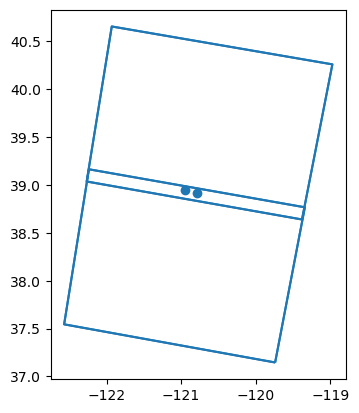

In [65]:
fig, ax = plt.subplots()

df_sites[df_sites.site_id.isin([166, 117])].plot(ax=ax)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')].exterior.plot(ax=ax)

### Filtering the SLCs by proximity to Site

Again, we can order the SLCs within flight direction (ascending/descending) and site according to the SLCs proximity to the site.

In [66]:
def distance_to_site_slc(row):
    poly_cent = row['geometry'].centroid
    site_id = row['site_id']
    site_geo = site_lut['geometry'][site_id]

    dist = site_geo.distance(poly_cent)
    return dist

In [67]:
df_slcs['dist_from_site_to_slc_centroid'] = df_slcs.apply(distance_to_site_slc, axis=1)
df_slcs[(df_slcs.jpl_burst_id == 't042_088909_iw2') & (df_slcs.date_acquired_str == '2021-08-14')]

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
9664,39.6564,-120.6329,2021-08-14 14:07:16+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:06:49+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,C-SAR,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,117,t042_088909_iw2,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",2021-08-14,0.751915
9663,38.1638,-120.9678,2021-08-14 14:07:41+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:07:14+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,C-SAR,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,117,t042_088909_iw2,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",2021-08-14,0.777644
14064,39.6564,-120.6329,2021-08-14 14:07:16+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:06:49+00:00,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,...,C-SAR,S1B_IWDV_0459_0466_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140649_20210814T1407...,IW,166,t042_088909_iw2,"POLYGON ((-119.37796 38.63911, -118.97026 40.2...",2021-08-14,0.769297
14063,38.1638,-120.9678,2021-08-14 14:07:41+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,DESCENDING,42,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2021-08-14 14:07:14+00:00,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,...,C-SAR,S1B_IWDV_0465_0470_028243_042,003.31,S1B_IW_SLC__1SDV_20210814T140714_20210814T1407...,IW,166,t042_088909_iw2,"POLYGON ((-119.73837 37.14591, -119.33971 38.7...",2021-08-14,0.792319


In [68]:
df_slcs.sort_values(by=['site_id', 'jpl_burst_id', 'date_acquired_str', 'dist_from_site_to_slc_centroid'], inplace=True)
df_slcs_filtered = df_slcs.groupby(['jpl_burst_id', 'date_acquired_str']).head(1)
df_slcs_filtered.shape

(25372, 29)

In [69]:
print('Total unique SLCs needed: ', len(df_slcs_filtered.fileID.unique()))

Total unique SLCs needed:  24213


In [70]:
df_slcs_filtered.to_dict('records')[0]

{'centerLat': -23.6783,
 'centerLon': -52.2085,
 'stopTime': Timestamp('2020-10-10 08:55:34+0000', tz='UTC'),
 'fileID': 'S1B_IW_SLC__1SDV_20201010T085507_20201010T085534_023748_02D20A_33A8-SLC',
 'flightDirection': 'DESCENDING',
 'pathNumber': 97,
 'processingLevel': 'SLC',
 'url': 'https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_SLC__1SDV_20201010T085507_20201010T085534_023748_02D20A_33A8.zip',
 'startTime': Timestamp('2020-10-10 08:55:07+0000', tz='UTC'),
 'sceneName': 'S1B_IW_SLC__1SDV_20201010T085507_20201010T085534_023748_02D20A_33A8',
 'browse': None,
 'platform': 'Sentinel-1B',
 'bytes': 4610088249,
 'md5sum': '20fa40d000b069e68d9af2a61c37a0ce',
 'frameNumber': 670,
 'granuleType': 'SENTINEL_1B_FRAME',
 'orbit': 23748,
 'polarization': 'VV+VH',
 'processingDate': Timestamp('2020-10-10 08:55:07+0000', tz='UTC'),
 'sensor': 'C-SAR',
 'groupID': 'S1B_IWDV_0670_0676_023748_097',
 'pgeVersion': '003.31',
 'fileName': 'S1B_IW_SLC__1SDV_20201010T085507_20201010T085534_023748_02D20A_33A8

In [71]:
df_slc_per_site_and_fa = df_slcs_filtered[['site_id', 'flightDirection', 'fileID']].groupby(['site_id', 'flightDirection']).count().sort_values(by='fileID', ascending=False).reset_index(drop=False)
df_slc_per_site_and_fa.head()

,site_id,flightDirection,fileID
0,261,ASCENDING,104
1,22,DESCENDING,104
2,72,ASCENDING,104
3,261,DESCENDING,104
4,150,ASCENDING,103


In [72]:
df_slc_per_site_and_fa.iloc[-4:]

,site_id,flightDirection,fileID
414,269,ASCENDING,1
415,108,DESCENDING,1
416,257,ASCENDING,1
417,282,ASCENDING,1


In [73]:
df_slcs_per_burst_and_site = df_slcs_filtered[['site_id', 'flightDirection', 'fileID', 'jpl_burst_id']].groupby(['site_id', 'jpl_burst_id', 'flightDirection']).size().reset_index(name='slc_count')
df_slcs_per_burst_and_site = df_slcs_per_burst_and_site.sort_values(by='slc_count', ascending=False).reset_index(drop=True)
df_slcs_per_burst_and_site.iloc[:4]

,site_id,jpl_burst_id,flightDirection,slc_count
0,261,t175_374038_iw1,ASCENDING,104
1,22,t021_043823_iw2,DESCENDING,104
2,72,t005_008692_iw2,ASCENDING,104
3,261,t022_045880_iw1,DESCENDING,104


In [74]:
df_slcs_filtered[df_slcs_filtered.site_id == 72].head()

,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,sceneName,...,sensor,groupID,pgeVersion,fileName,beamModeType,site_id,jpl_burst_id,geometry,date_acquired_str,dist_from_site_to_slc_centroid
5740,18.2175,-97.7531,2020-10-04 00:39:54+00:00,S1B_IW_SLC__1SDV_20201004T003926_20201004T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-04 00:39:26+00:00,S1B_IW_SLC__1SDV_20201004T003926_20201004T0039...,...,C-SAR,S1B_IWDV_0054_0060_023656_005,003.31,S1B_IW_SLC__1SDV_20201004T003926_20201004T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09221 18.84333, -98.74215 17.158...",2020-10-04,0.557993
5739,17.7484,-97.6504,2020-10-10 00:40:28+00:00,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-10 00:40:01+00:00,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,...,C-SAR,S1A_IWDV_0052_0058_034727_005,003.31,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,IW,72,t005_008692_iw2,"POLYGON ((-98.98721 18.34436, -98.64935 16.715...",2020-10-10,0.236081
5738,18.2172,-97.7526,2020-10-16 00:39:54+00:00,S1B_IW_SLC__1SDV_20201016T003926_20201016T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-16 00:39:26+00:00,S1B_IW_SLC__1SDV_20201016T003926_20201016T0039...,...,C-SAR,S1B_IWDV_0054_0060_023831_005,003.31,S1B_IW_SLC__1SDV_20201016T003926_20201016T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09180 18.84317, -98.74171 17.157...",2020-10-16,0.557546
5737,17.7486,-97.6494,2020-10-22 00:40:27+00:00,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...,2020-10-22 00:40:00+00:00,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,...,C-SAR,S1A_IWDV_0053_0058_034902_005,003.31,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,IW,72,t005_008692_iw2,"POLYGON ((-98.98630 18.34443, -98.64847 16.715...",2020-10-22,0.235131
5736,18.2175,-97.7530,2020-10-28 00:39:54+00:00,S1B_IW_SLC__1SDV_20201028T003926_20201028T0039...,ASCENDING,5,SLC,https://datapool.asf.alaska.edu/SLC/SB/S1B_IW_...,2020-10-28 00:39:26+00:00,S1B_IW_SLC__1SDV_20201028T003926_20201028T0039...,...,C-SAR,S1B_IWDV_0054_0059_024006_005,003.31,S1B_IW_SLC__1SDV_20201028T003926_20201028T0039...,IW,72,t005_008692_iw2,"POLYGON ((-99.09225 18.84338, -98.74213 17.157...",2020-10-28,0.557986


In [75]:
df_slcs_per_burst_and_site.iloc[-4:]

,site_id,jpl_burst_id,flightDirection,slc_count
414,269,t149_319844_iw1,ASCENDING,1
415,108,t130_277443_iw3,ASCENDING,1
416,257,t086_184583_iw1,ASCENDING,1
417,282,t086_184581_iw2,ASCENDING,1


Simply due to S1A/S1B availability, we see that certain bursts have less than the expected number of samples. Filtering by frequency ensure we will have a dense time series.

In [76]:
df_val_bursts_with_count = pd.merge(df_val_bursts_filtered, 
                                   df_slcs_per_burst_and_site[['site_id', 'jpl_burst_id', 'slc_count']], 
                                  on=['site_id','jpl_burst_id'], 
                                  how='left')
# Some bursts have no counts and are therefore NA
df_val_bursts_with_count.dropna(axis=0, subset=['slc_count'], inplace=True)
df_val_bursts_with_count.head()

,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number,dist_from_site_to_burst_centroid,slc_count
1,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1...",t097_207419_iw2,1,False,DESCENDING,1,VLmaj,2021-10-08,NaT,97,0.258936,37.0
3,"POLYGON ((130.49640 -29.60892, 129.63063 -29.4...",t075_160202_iw1,1,False,DESCENDING,2,noChange,NaT,NaT,75,0.182747,36.0
4,"POLYGON ((-99.31968 33.56634, -98.35539 33.705...",t107_227877_iw2,1,True,ASCENDING,3,VLmin,2022-01-28,2022-01-06,107,0.257018,65.0
7,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",t036_076228_iw3,1,False,DESCENDING,4,VLmaj,2021-11-07,2021-11-02,36,0.122383,100.0
9,"POLYGON ((115.83357 63.15873, 114.26731 63.282...",t091_194011_iw3,1,False,DESCENDING,5,VLmaj,2022-05-18,2022-05-11,91,0.611896,4.0


In [77]:
sufficient_sampling_ind = df_val_bursts_with_count.slc_count >= MINIMUM_SAMPLES_PER_SITE_AND_BURST
bursts_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].jpl_burst_id.unique()
print('Total bursts with enough samples: ', (sufficient_sampling_ind).sum())
print('Total bursts available (i.e. with SLCs): ', len(df_val_bursts_with_count.jpl_burst_id.unique()))

Total bursts with enough samples:  86
Total bursts available (i.e. with SLCs):  418


In [78]:
sites_with_enough_samples = df_val_bursts_with_count[sufficient_sampling_ind].site_id.unique().tolist()
print('Total sites with enough samples: ', len(sites_with_enough_samples))
print('Total sites available (i.e. with SLCs): ', len(df_val_bursts_with_count.site_id.unique()))

Total sites with enough samples:  53
Total sites available (i.e. with SLCs):  289


In [79]:
df_val_bursts_tropical = df_val_bursts_with_count.cx[:, -TROPICAL_BUFFER_DEG: TROPICAL_BUFFER_DEG].reset_index(drop=True)
df_val_bursts_tropical_top = df_val_bursts_tropical.sort_values(by=['slc_count'], ascending=False).head(N_TROPICAL_SITES)
print(df_val_bursts_tropical_top.slc_count.sum())
df_val_bursts_tropical_top.head()

636.0


,geometry,jpl_burst_id,is_land,is_north_america,orbit_pass,site_id,change_label,change_time,last_observation_time,track_number,dist_from_site_to_burst_centroid,slc_count
0,"POLYGON ((19.82686 4.63062, 19.12143 4.78148, ...",t036_076228_iw3,1,False,DESCENDING,4,VLmaj,2021-11-07,2021-11-02,36,0.122383,100.0
3,"POLYGON ((33.63176 4.04588, 32.87115 4.21002, ...",t123_263100_iw1,1,False,DESCENDING,73,VLmin,2021-12-12,2021-12-06,123,0.133175,81.0
1,"POLYGON ((-48.48824 -1.27442, -49.28340 -1.097...",t170_364085_iw2,1,False,DESCENDING,66,noChange,NaT,NaT,170,0.078428,69.0
9,"POLYGON ((-42.63028 -2.73766, -43.42608 -2.559...",t126_269585_iw2,1,False,DESCENDING,288,VLmaj,2021-10-03,NaT,126,0.310546,67.0
2,"POLYGON ((33.10028 3.85437, 33.80708 3.99703, ...",t029_060159_iw3,1,False,ASCENDING,73,VLmin,2021-12-12,2021-12-06,29,0.083633,65.0


In [80]:
top_tropical_bursts = df_val_bursts_tropical_top.jpl_burst_id.unique()
print('SLCs used for tropical coverage: ', len(df_slcs_filtered[df_slcs_filtered.jpl_burst_id.isin(top_tropical_bursts)].fileID.unique()))

SLCs used for tropical coverage:  636


<Axes: >

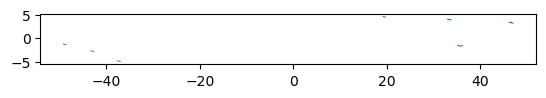

In [81]:
df_val_bursts_tropical_top.plot()

In [93]:
ind_samples = df_slcs_filtered.jpl_burst_id.isin(bursts_with_enough_samples)

tropical_burst_ids = df_val_bursts_tropical_top.jpl_burst_id.unique().tolist()
ind_tropical = df_slcs_filtered.jpl_burst_id.isin(tropical_burst_ids)

df_slcs_final = df_slcs_filtered[ind_samples | ind_tropical].reset_index(drop=True)
print('Final tally of SLCs: ', len(df_slcs_final.fileID.unique()))

Final tally of SLCs:  8703


Let's visualize the sites

In [83]:
df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].change_time

3     2021-11-07
12    2021-10-03
21    2021-12-19
29           NaT
33    2021-10-22
39    2021-10-03
54    2021-10-15
65           NaT
71           NaT
72    2021-12-12
86    2022-01-11
87           NaT
89           NaT
94    2022-07-12
97    2022-06-15
103          NaT
114          NaT
116          NaT
121          NaT
125   2022-09-09
146          NaT
147          NaT
149   2021-12-30
153   2022-07-16
157   2021-11-13
165          NaT
171          NaT
174   2022-03-12
177   2022-07-14
179   2022-02-26
188   2022-07-07
191   2021-10-08
203   2022-08-26
204   2022-01-19
205          NaT
211   2021-10-10
221          NaT
223   2021-10-15
225   2021-10-10
227          NaT
234   2022-05-08
247   2022-07-20
248   2022-01-28
249   2022-09-03
250          NaT
254   2022-04-05
255   2022-01-17
260   2021-10-04
262          NaT
263   2022-01-21
269          NaT
271   2021-10-04
273   2021-10-08
286          NaT
287   2021-10-03
291          NaT
293   2022-02-12
295   2022-06-30
298          N

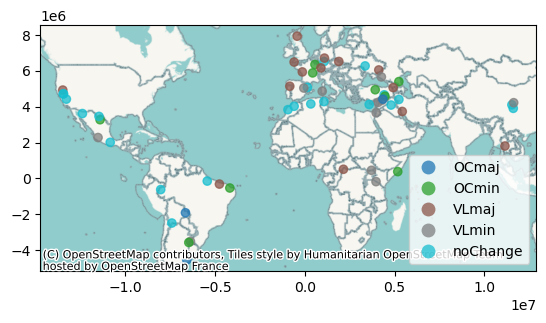

In [84]:
ax = df_sites[df_sites.site_id.isin(df_slcs_final.site_id.unique())].to_crs(epsg=3857).plot(alpha=.75,column='change_label', categorical=True, legend=True)
cx.add_basemap(ax)

We can now plot the SLC frames with a given site.

In [85]:
df_slcs_final.site_id.unique()

array([  4,  13,  22,  30,  34,  40,  55,  66,  72,  73,  87,  88,  90,
        95,  98, 104, 115, 117, 122, 126, 147, 148, 150, 154, 158, 166,
       172, 175, 178, 180, 189, 192, 204, 205, 206, 212, 222, 224, 226,
       228, 235, 248, 249, 250, 251, 255, 256, 261, 263, 264, 270, 272,
       274, 287, 288, 292, 294, 296, 299])

<Axes: >

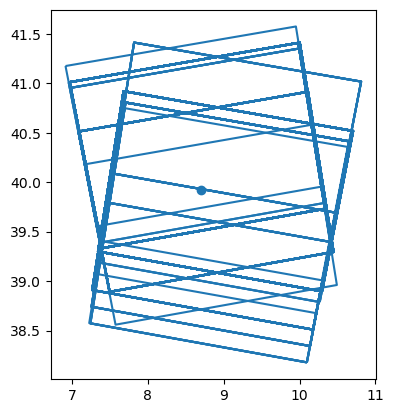

In [86]:
fig, ax = plt.subplots()

site_id_sample = 274
df_slcs_final[df_slcs_final.site_id == site_id_sample].exterior.plot(ax =ax)
df_sites[df_sites.site_id == site_id_sample].plot(ax=ax)

In [91]:
compression_options = dict(method='zip', archive_name=f'slcs_for_processing.csv')
df_slcs_final.to_csv('slcs_for_processing.csv.zip', compression=compression_options, index=False)

This is the total cost assuming $0.35 / day.

In [95]:
df_slcs_final.startTime.max(), df_slcs_final.startTime.min()

(Timestamp('2022-11-30 17:57:02+0000', tz='UTC'),
 Timestamp('2020-10-01 01:58:32+0000', tz='UTC'))

In [92]:
(len(df_slcs_final.fileID.unique())) * .35

3046.0499999999997